In [6]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [ ]:
# !pip install plotly

In [38]:
import pandas as pd
import numpy as np

# from tqdm.notebook import tqdm

from scipy import stats

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import plotly.express as px
import plotly.graph_objects as go

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

In [39]:
lat_min = 35.71
lat_max = 36.55
lon_min = -84.55
lon_max = -82.37

# Potential extra practice:
#  * plot all the starbs locations in one color
#  * plot my location in a different color
adam_lat = 36.3
adam_lon = -82.4

data_url = "https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/Data%20Sets%20Clustering/starbucks_locations.csv"
starbs = pd.read_csv(data_url)

starbs = starbs[starbs["Latitude"].between(lat_min, lat_max)]
starbs = starbs[starbs["Longitude"].between(lon_min, lon_max)]
starbs.head(3)

,Brand,Store Number,Store Name,Ownership Type,Street Address,City,State/Province,Country,Postcode,Phone Number,Timezone,Longitude,Latitude
22859,Starbucks,3509-142865,TYS Foodcourt (Knoxville),Licensed,2055 Airport Hwy,Alcoa,TN,US,377013316,NaN,GMT-05:00 America/New_York,-83.99,35.81
22860,Starbucks,11293-104144,Cusick & Alcoa,Company Owned,121 Cusick Rd,Alcoa,TN,US,377013125,865-982-0642,GMT-05:00 America/New_York,-83.98,35.81
22895,Starbucks,18984-190185,Ingles Farragut # 91,Licensed,11817 Kingston Pike,Farragut,TN,US,37934,865-777-4360,GMT-05:00 America/New_York,-84.12,35.90


<IPython.core.display.Javascript object>

## 🔥 Warm up 🔥

According to the distribution of our filtered data in the `starbs` dataframe.

We're most likely to find a starbucks at which of these values of `'Longitude'`?
* (A) -81
* (B) -83
* **(C) -84**
* (D) -85

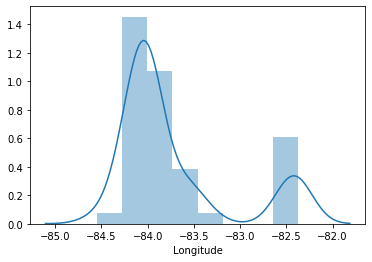

<IPython.core.display.Javascript object>

In [40]:
sns.distplot(starbs["Longitude"])
plt.show()

According to the distribution of our filtered data in the `starbs` dataframe.

We're most likely to find a starbucks at which of these values of `'Latitude'`?
* (A) 35
* **(B) 36**
* (C) 37
* (D) 38

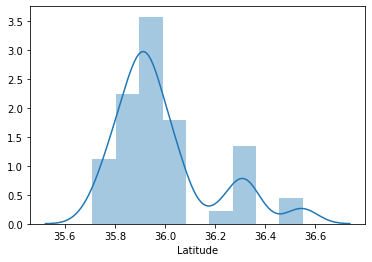

<IPython.core.display.Javascript object>

In [41]:
sns.distplot(starbs["Latitude"])
plt.show()

## Gaussian Mixture Model

gaussian distribution = normal distribution
 
### MLE

We're given the below data, and we're told that the data is measurements of some snail characteristic 🐌.  We want to try and figure out what the *population* distribution looks like.  Remember we just have a *sample*, but the population is all of the snail species we're studying.  Having a good estimate of this population distribution can benefit and guide our analysis.

In [42]:
# fmt: off
data = [ 8.521, 16.586, 11.154,  3.323, 13.662, 14.649,  6.149,  5.528,
        18.871, 11.498,  8.921,  5.776,  7.292,  6.638, 13.321,  7.073,
         8.827, 10.375,  1.645, 13.566, 19.846,  6.347,  8.617, 14.462,
         4.483, 11.170, 11.322,  5.710, 11.311,  7.672,  9.765, 14.443,
        18.360,  9.304, 10.247, 10.955, 14.194,  8.344,  5.783, 12.533,
        12.937,  0.846,  4.925,  9.006, 11.443, 16.160, 10.751,  8.513,
        23.865, 17.228]

<IPython.core.display.Javascript object>

* Before plotting:
    * What kind of distribution do you expect this type of data to follow?
    * What 'parameters' does that distribution have?
        * i.e. these are what you'd need to give `np.random.<distribution_name>()` so it can know what shape of distribution you want random numbers from


* Now let's plot a histogram.  Does the shape of the data's distribution support your hypothesis?

In [43]:
len(data)

50

<IPython.core.display.Javascript object>

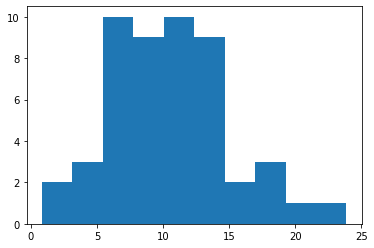

<IPython.core.display.Javascript object>

In [44]:
plt.hist(data)
plt.show()

Remember, we're after the population distribution.

* Re-plot the histogram
* Add a vertical line at 20 (color it and give it a label for the legend)
* Add a vertical line at 10 (color it and give it a label for the legend)
* Add a vertical line at  5 (color it and give it a label for the legend)

Let's say these are 3 guesses at what the population mean are.  Given our data, which of these is the most *likely*.  Due to the nature of random sampling, it's possible that all 3 of these are valid, but we it's not practical to assume that we got a very unusual random sample.

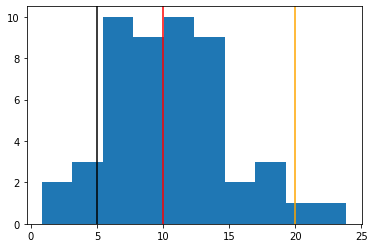

<IPython.core.display.Javascript object>

In [45]:
plt.hist(data)
plt.axvline(20, c="orange", label="20")
plt.axvline(10, c="red", label="10")
plt.axvline(5, c="black", label="5")
plt.show()

We're engaging in a process called Maximum Likelihood Estimation (MLE).  We're trying to Estimate the population mean based on what's most Likely.  We want our Estimate to have the Maximum Likelihood of being correct.

Below is a visualization of us trying to find the population mean via MLE.

Note, this is why the mean parameter of `np.random.normal` is called `loc`.

<img src='images/mean_mle.gif' width=70%>

There's one more parameter we'd need to esimate in order to fully describe our distribution's shape.  This is why this parameter in `np.random.normal` is called `scale` (we scale the width, the height is derived from the width).

<img src='images/std_mle.gif' width=60%>

In this case, the maximum likelihood estimates for the population mean and standard deviation are the equal to the sample mean and sample standard deviations.

* Generate 1000 random data points from our estimate popuation distribution
* Plot this resulting distribution, compare it to our sample

In [46]:
np.mean(data)

10.478339999999998

<IPython.core.display.Javascript object>

In [47]:
np.std(data)

4.701991733765596

<IPython.core.display.Javascript object>

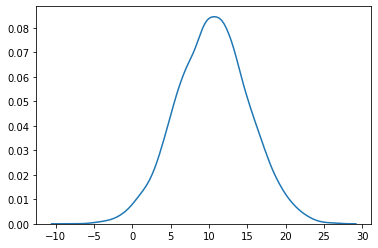

<IPython.core.display.Javascript object>

In [48]:
sample = np.random.normal(10.478, 4.702, size=10000)
sns.distplot(sample, hist=False)
plt.show()

### Mixing

We just got some new data.  This data was collected from 2 separate species of snails 🐌.

We know these snails each follow a normal distribution, and we know that they have different means & standard deviations.  Unfortunately, the scientist in the field didn't write down which species each observation is, so we have to try and figure out these 2 separate distributions from a sample of mixed data.

If we knew the species labels, we could perform the same MLE process we did above (filter and perform MLE 1 at a time).

In [49]:
# fmt: off
data = [11.83984961, 12.37143473, 26.15417807, 28.58500880, 27.70571253,
        24.24028217, 18.33611103, 15.28117383, 14.57235710, 18.49006327,
        37.83761751, 18.82148403, 36.62430095, 26.61444903, 15.3433858 ,
        24.60865873, 31.67437436, 26.08487739, 14.75279305, 25.63485726,
        30.44683604, 29.64163292, 14.91536797, 20.48912193, 27.97187397,
        11.41235662, 17.90399557, 33.82514212, 17.71352474, 25.98954934,
        19.86878159, 26.92304096, 16.25738730, 29.10667734, 31.06548273,
        21.14768063, 29.93913722, 25.32381510, 18.98788655, 16.60772929,
        25.00896332, 17.41901911, 14.21902871, 27.90108363, 26.99118323,
        26.03784060, 31.83483958, 25.73633429, 31.48278996, 24.23683382,
        19.24019041, 14.73365444, 27.70687662, 19.82397780, 14.58054905,
        22.51116415, 21.31616800, 26.34025573, 28.45094146, 24.61646750]

<IPython.core.display.Javascript object>

Plot the distribution of the data.  Do you think we'll be able to separate out 2 normal distributions from it?

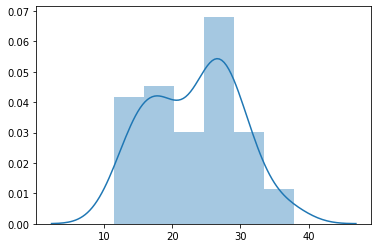

<IPython.core.display.Javascript object>

In [50]:
sns.distplot(data)
plt.show()

To figure this out, we'll throw in some initial guesses.

In [51]:
def plot_guess(
    data, x1_mean, x1_std, x2_mean, x2_std, n=int(1e6), prob_1=None, prob_2=None
):
    """Helper function for plotting GMM process"""
    sns.distplot(np.random.normal(x1_mean, x1_std, n), hist=False)
    sns.distplot(np.random.normal(x2_mean, x1_std, n), hist=False)

    if prob_1 is not None and prob_2 is not None:
        prob_1 = MinMaxScaler().fit_transform(prob_1)
        prob_2 = MinMaxScaler().fit_transform(prob_2)

        for x, p1, p2 in zip(data, prob_1, prob_2):
            if p1 > p2:
                c = "blue"
                alpha = p1[0]
            else:
                c = "orange"
                alpha = p2[0]

            plt.scatter(x, 0, alpha=alpha * 0.8, c=c)
    else:
        plt.scatter(data, [0 for _ in data], c="black")

    plt.yticks([])

<IPython.core.display.Javascript object>

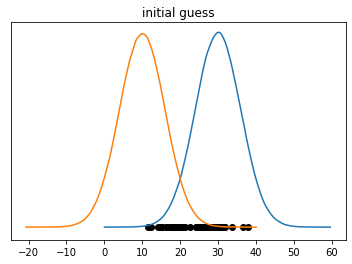

<IPython.core.display.Javascript object>

In [52]:
plot_guess(data, x1_mean=30, x1_std=6, x2_mean=10, x2_std=6)
plt.title("initial guess")
plt.show()

Thanks to these distributions, we can now assign a probability (or likelihood) that each point came from each distribution.  Using this, we can split the data into 2 groups:

* (1) points more likely to have come from the orange distribution
* (2) points more likely to have come from the blue distribution

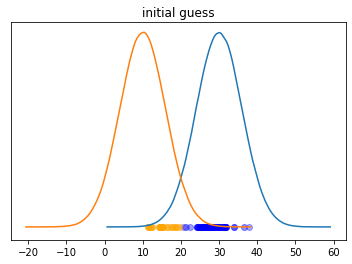

<IPython.core.display.Javascript object>

In [53]:
df = pd.DataFrame(data, columns=["mixture"])
df["prob_blue"] = stats.norm(30, 6).pdf(df["mixture"])
df["prob_orange"] = stats.norm(10, 6).pdf(df["mixture"])
df["label"] = "blue"
df.loc[df["prob_orange"] > df["prob_blue"], "label"] = "orange"

plot_guess(
    data,
    x1_mean=30,
    x1_std=6,
    x2_mean=10,
    x2_std=6,
    prob_1=df[["prob_blue"]],
    prob_2=df[["prob_orange"]],
)
plt.title("initial guess")
plt.show()

We now have 2 individual groups of data! And just like in the single species example, we can now make a better guess about what each distribution looks like.  We can use this to update our guess of the distribution shapes.

In [54]:
df.groupby("label").agg({"mixture": ["mean", "std"]})

mixture          
             mean       std
label                      
blue    27.508272  3.867000
orange  16.238787  2.525888

<IPython.core.display.Javascript object>

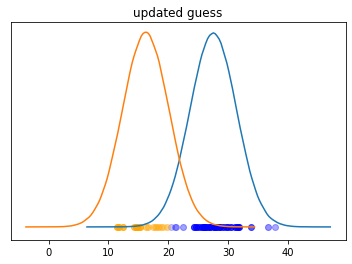

<IPython.core.display.Javascript object>

In [55]:
plot_guess(
    data,
    x1_mean=27.508272,
    x1_std=3.867000,
    x2_mean=16.238787,
    x2_std=2.525888,
    prob_1=df[["prob_blue"]],
    prob_2=df[["prob_orange"]],
)
plt.title("updated guess")
plt.show()

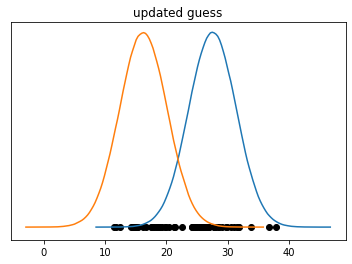

<IPython.core.display.Javascript object>

In [56]:
plot_guess(
    data, x1_mean=27.508272, x1_std=3.867000, x2_mean=16.238787, x2_std=2.525888,
)
plt.title("updated guess")
plt.show()

And repeat! This process we just went through goes by the name Gussian Mixture Modeling.  Gaussian is another name for the normal distribution (named after a dude who contributed a lot to math and statistics).

Let's see how we can approach this problem with sklearn.

In [57]:
gmm = GaussianMixture(2)
gmm.fit(df[["mixture"]])

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

<IPython.core.display.Javascript object>

Here are the means and standard deviations that sklearn settled on after going through that process a couple more iterations.  Note that in this simple case, our 1 iteration algorithm got pretty similar results.

Cluster 1 - mean: 16.57; std: 2.79
Cluster 2 - mean: 27.61; std: 3.86


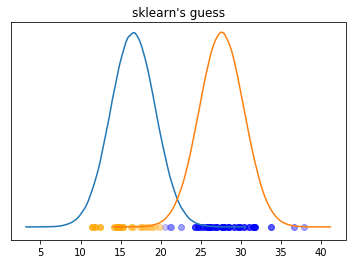

<IPython.core.display.Javascript object>

In [58]:
x1_mean, x2_mean = gmm.means_
x1_std, x2_std = np.sqrt(gmm.covariances_)

x1_mean = x1_mean[0]
x2_mean = x2_mean[0]
x1_std = x1_std[0][0]
x2_std = x2_std[0][0]

print(f"Cluster 1 - mean: {x1_mean:.2f}; std: {x1_std:.2f}")
print(f"Cluster 2 - mean: {x2_mean:.2f}; std: {x2_std:.2f}")

plot_guess(
    data,
    x1_mean=x1_mean,
    x1_std=x1_std,
    x2_mean=x2_mean,
    x2_std=x2_std,
    prob_1=df[["prob_blue"]],
    prob_2=df[["prob_orange"]],
)
plt.title("sklearn's guess")
plt.show()

That's cool and all, but our data almost never has just a single column (i.e. this example was *univariate*).  Let's look at a case with multiple variables (i.e. *multivariate*).

In [71]:
lat_lon = starbs[["Latitude", "Longitude"]].copy()

fig = px.scatter_geo(lat_lon, "Latitude", "Longitude", scope="usa")
fig.update_geos(fitbounds="locations")
fig.show()

<IPython.core.display.Javascript object>

We can try and visualize both distributions at once using a couple different methods

In [60]:
px.scatter(
    starbs, "Longitude", "Latitude", marginal_x="histogram", marginal_y="histogram"
)

<IPython.core.display.Javascript object>

In [61]:
x = starbs["Longitude"]
y = starbs["Latitude"]
kernel = stats.gaussian_kde((x, y))

x = np.linspace(x.min(), x.max(), 100)
y = np.linspace(y.min(), y.max(), 100)

z = []
for xi in x:
    zi = []
    for yi in y:
        zi.append(kernel((xi, yi))[0])

    z.append(zi)

z = np.array(z)
z.reshape((x.shape[0], y.shape[0]))

fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])
fig.show()

<IPython.core.display.Javascript object>

Just like KMeans, we need to decide up front how many clusters we want the clustering process to find.

In [62]:
k = 4

<IPython.core.display.Javascript object>

* Create and fit a `GaussianMixture()` model

In [63]:
gauss = GaussianMixture(n_components=k, random_state=42)
gauss.fit(lat_lon)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=4, n_init=1, precisions_init=None,
                random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

<IPython.core.display.Javascript object>

Let's compare `GaussianMixture()` to `KMeans()`.

* Create and fit a `KMeans()` model

In [64]:
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(lat_lon)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

<IPython.core.display.Javascript object>

* Print the resulting centroids from each method

In [65]:
gauss.means_

array([[ 35.92205702, -84.0705724 ],
       [ 36.37125   , -82.42125   ],
       [ 35.80598724, -83.56399839],
       [ 36.2       , -83.35      ]])

<IPython.core.display.Javascript object>

In [66]:
kmeans.cluster_centers_

array([[ 35.92846154, -84.01230769],
       [ 36.37125   , -82.42125   ],
       [ 35.90125   , -84.26      ],
       [ 35.87166667, -83.52833333]])

<IPython.core.display.Javascript object>

In [67]:
starbs["label"] = gauss.predict(lat_lon)

<IPython.core.display.Javascript object>

In [68]:
# starbs[starbs["label"] == 0]

<IPython.core.display.Javascript object>

* Use the `GaussianMixture.predict_proba()` method.
* What are the top 3 observations we are least confident about?
* What are the top 3 observations we are most confident about?

In [69]:
prob_df = pd.DataFrame(gauss.predict_proba(lat_lon))
prob_df.head()

,0,1,2,3
0,1.0,0.000000e+00,2.767721e-189,0.0
1,1.0,0.000000e+00,1.945353e-180,0.0
2,1.0,0.000000e+00,2.787396e-292,0.0
3,1.0,0.000000e+00,0.000000e+00,0.0
4,1.0,6.171589e-316,3.185780e-86,0.0


<IPython.core.display.Javascript object>

Visualizing the results comparison:

In [70]:
plot_df = lat_lon.copy()
plot_df["label"] = gauss.predict(lat_lon)
plot_df = plot_df.sort_values("label")

centers_df = pd.DataFrame(gauss.means_, columns=["Latitude", "Longitude"])
centers_df["label"] = "Cluster center"

plot_df = pd.concat((plot_df, centers_df), sort=False)

fig = px.scatter_geo(
    plot_df,
    "Latitude",
    "Longitude",
    color="label",
    scope="usa",
    title="Gaussian Mixture Model Results",
    hover_name=plot_df.index,
)

fig.update_geos(fitbounds="locations")
fig.show()

# ----------------------------------------------------------------------------

plot_df = lat_lon.copy()
plot_df["label"] = kmeans.labels_
plot_df = plot_df.sort_values("label")

centers_df = pd.DataFrame(kmeans.cluster_centers_, columns=["Latitude", "Longitude"])
centers_df["label"] = "Cluster center"

plot_df = pd.concat((plot_df, centers_df), sort=False)

fig = px.scatter_geo(
    plot_df,
    "Latitude",
    "Longitude",
    color="label",
    scope="usa",
    title="KMeans Results",
    hover_name=plot_df.index,
)

fig.update_geos(fitbounds="locations")
fig.show()

<IPython.core.display.Javascript object>

## Mean-shift

* Use `matplotlib` to plot the East TN Starbucks
* Label the `x` and `y` axes
* Give the plot a title

* Use `sns.kdeplot()` to show the distribution of Latitude and Longitude separately.
* How many clusters do you expect to find if clustering only on one of these variables?
* Play with the `bw` parameter of `sns.kdeplot()`.  How does this change how many clusters you expect?

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.kdeplot(____, ax=axes[0])
sns.kdeplot(____, ax=axes[1])
plt.show()

* Use `sns.kdeplot()` to show the 2d distribution of Latitude and Longitude.
* Add the starbucks locations to the plot.
* How many clusters do you expect to find if clustering only on one of these variables?
* Play with the `bw` parameter of `sns.kdeplot()`.  How does this change how many clusters you expect?

In [ ]:
sns.kdeplot(____)
plt.scatter(____)
plt.show()

A slightly different view of the same plot.

In [ ]:
bw = 0.1

x = starbs["Longitude"]
y = starbs["Latitude"]
kernel = stats.gaussian_kde((x, y), bw_method=bw)

x = np.linspace(x.min(), x.max(), 100)
y = np.linspace(y.min(), y.max(), 100)

z = []
for xi in x:
    zi = []
    for yi in y:
        zi.append(kernel((xi, yi))[0])

    z.append(zi)

z = np.array(z)
z.reshape((x.shape[0], y.shape[0]))

fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])
fig.show()

* Use `MeanShift()` to cluster the observations
* The default `bandwidth` used by `MeanShift()` is calculated using `sklearn.cluster.estimate_bandwidth()` (shown below)

In [ ]:
default_bw = estimate_bandwidth(lat_lon)
print(f"Default bandwidth: {default_bw}")

In [ ]:
# Define a variable to hold the selected bw for use in plotting later
bw = _____

____

* Show the resulting cluster centers.  How many clusters were found?

* Redo the above plot colored by cluster label

In [ ]:
# seaborn converts all columns that look like numbers to numeric
# we dont want a color bar to represent cluster labels as they're purely
# categorical. to stop seaborn from thinking of our labels as continuous
# we're adding cluster labels as strings and adding an underscore

lat_lon["label"] = mean_shift.labels_.astype(str)
lat_lon["label"] += "_"

In [ ]:
sns.kdeplot(____)
sns.scatterplot(____)

plt.title("Clustered East TN Starbucks")
plt.legend(loc="lower right")
plt.show()

#### Extra practice in case we have time:

* The nba dataset is loaded & cleaned for you below.
* Apply mean shift and interpret the clusters.
* Based on your interpretation, are these good clusters?

In [ ]:
data_url = "https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/Data%20Sets%20Clustering/nba_player_seasons.csv"
nba = pd.read_csv(data_url)

nba = nba[(nba["GS"] >= 20) & (nba["MP"] >= 10)]
nba = nba.dropna().reset_index(drop=True)
nba_og = nba.copy()

nba = nba[["PTS", "TRB", "TOV", "AST", "BLK", "Age"]]
nba.head(3)